## Packages

In [1]:
import numpy as np # is the fundamental package for scientific computing with Python.
import matplotlib.pyplot as plt
import h5py # is a common package to interact with a dataset that is stored on an H5 file.
import scipy # are used here to test the model with own picture at the end.
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## Loading the data

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

## Exploring Data

y = [1], it's a 'cat' picture.


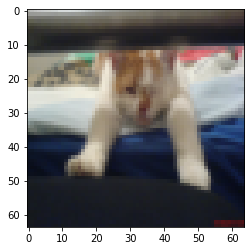

In [9]:
index = 29
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [10]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


## Reshape values

In [11]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

## Standardize dataset

In [12]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## Logistic Regression, using a Neural Network mindset

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## Sigmoid Function

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

In [14]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

### Initializing parameters

In [17]:
def initialize_with_zeros(dim):
    w = np.zeros([dim, 1])
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

## Forward and Backward propagation

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [18]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X) + b) # compute activation
    cost = -1/m * (np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1 - A).T)) # compute cost
    
    dw = 1 / m *(np.dot(X,(A - Y).T))
    db = 1 / m *(np.sum(A - Y))
    
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

## Optimization

The goal is to learn $w$ and $b$ by minimizing the cost function $J$. 

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [19]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        
        
        grads, cost = propagate(w,b,X,Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## Predict function. 

There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction.

In [20]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b) 
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if(A[0][i] <= 0.5):
            Y_prediction[0][i] = 0
        else:
            Y_prediction[0][i] = 1
        
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction